<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/grid_search_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on article: https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [279]:
from itertools import product
import pandas as pd

In [280]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [281]:
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [282]:
df = pd.read_csv("https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/traffic.txt", names=['col'])
df.index = pd.date_range(start='1/1/2016', freq="D", periods=len(df))

In [283]:
# df.tail()

In [284]:
# ibc_path = "/content/drive/My Drive/Colab Notebooks/emprego/bases/IBCR-PE.csv"
# df = pd.read_csv(ibc_path, sep=';', index_col='data', usecols=['data', 'indice'], decimal=',')
# df.index = pd.to_datetime(df.index, format="%m/%Y")

In [285]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, 
                 enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict()
	return yhat
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, percent_test=0.25):
  n_test = int(len(data) * percent_test)
  return data[:-n_test], data[-n_test:]

In [286]:
# walk-forward validation for univariate data
def walk_forward_validation(data, percent_test, cfg):

  # split dataset
  train, test = train_test_split(data, percent_test)

  # fit model and make forecast for history
  yhat = sarima_forecast(train, cfg)

  # estimate prediction error
  error = measure_rmse(train, yhat)
  return error  

In [287]:
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
      # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

In [288]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

In [289]:
# evaluating grid search results for test data
def test_grid_search_results(data, scores, ntop_scores=5):

  if ntop_scores > len(scores):
    ntop_scores = 5

  scores_test = list()
  _, test = train_test_split(data)  

  for cfg_str, _ in scores[:ntop_scores]:
    cfg = eval(cfg_str)
    with catch_warnings():
      filterwarnings("ignore")
      yhat = sarima_forecast(test, cfg)
    error = measure_rmse(test, yhat)
    result = (cfg_str, error)
    print(result)
    scores_test.append(result)
  
  scores_test.sort(key=lambda tup: tup[1])
  return scores_test

In [290]:
def sarima_configs(seasonal=[12]):
  models = list()
  # define config lists
  p_params = [0, 1, 2]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n']#,'c','t','ct']
  P_params = [0, 1]
  D_params = [0, 1]
  Q_params = [0, 1]
  m_params = seasonal
  # create config instances
  for p, d, q, t, P, D, Q, m in product(p_params, d_params, q_params, t_params, P_params, D_params, Q_params, m_params):
    cfg = [(p,d,q), (P,D,Q,m), t]
    models.append(cfg)
  return models

In [291]:
def plot_model(data, cfg):
  order = cfg[0]
  s_order = cfg[1]
  trend = cfg[2]
  sarimax_pred = SARIMAX(
      endog=df, order=order, seasonal_order=s_order, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)

  model_sarimax_pred = sarimax_pred.fit(disp=False)

  previsao_sarimax = model_sarimax_pred.predict()

  error = measure_rmse(df, previsao_sarimax)
  print('Error:', error)

  plt.figure(figsize=(22, 10))
  plt.plot(previsao_sarimax, label = 'forecast')
  plt.plot(df, label = 'target')
  plt.title('Target x Forecast')
  plt.legend()
  plt.show()

In [292]:
cfg_list = sarima_configs(seasonal=[12])
scores = grid_search(df, cfg_list, 0.25)

 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 49596.069
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 28261.993
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 40777.715
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 27132.365
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 20058.409
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 20081.917
 > Model[[(0, 0, 1), (0, 0, 0, 12), 'n']] 26022.079
 > Model[[(0, 0, 1), (0, 0, 1, 12), 'n']] 21473.217
 > Model[[(0, 0, 1), (0, 1, 0, 12), 'n']] 15755.362
 > Model[[(0, 0, 0), (1, 1, 0, 12), 'n']] 14494.377
 > Model[[(0, 0, 0), (1, 1, 1, 12), 'n']] 14227.104
 > Model[[(0, 0, 1), (0, 1, 1, 12), 'n']] 12135.566
 > Model[[(0, 0, 1), (1, 0, 0, 12), 'n']] 15077.032
 > Model[[(0, 0, 1), (1, 0, 1, 12), 'n']] 12085.782
 > Model[[(0, 0, 2), (0, 0, 0, 12), 'n']] 15675.368
 > Model[[(0, 0, 1), (1, 1, 0, 12), 'n']] 8938.450
 > Model[[(0, 0, 1), (1, 1, 1, 12), 'n']] 8729.730
 > Model[[(0, 0, 2), (0, 0, 1, 12), 'n']] 21494.438
 > Model[[(0, 0, 2), (0, 1, 0, 12), 'n']] 10740.472
 > Model[[(0, 

In [293]:
scores[:3]

[("[(2, 1, 0), (1, 1, 0, 12), 'n']", 3944.137740993967),
 ("[(1, 1, 2), (1, 1, 0, 12), 'n']", 3948.054958267473),
 ("[(2, 1, 0), (1, 1, 1, 12), 'n']", 3949.0915811309064)]

In [294]:
test_scores = test_grid_search_results(df, scores)

("[(2, 1, 0), (1, 1, 0, 12), 'n']", 3347.4757704294325)
("[(1, 1, 2), (1, 1, 0, 12), 'n']", 3349.592138078444)
("[(2, 1, 0), (1, 1, 1, 12), 'n']", 3350.9803864159476)
("[(1, 1, 1), (1, 1, 1, 12), 'n']", 3348.8444599753316)
("[(1, 1, 1), (1, 1, 0, 12), 'n']", 3345.61898587995)


In [295]:
test_scores

[("[(1, 1, 1), (1, 1, 0, 12), 'n']", 3345.61898587995),
 ("[(2, 1, 0), (1, 1, 0, 12), 'n']", 3347.4757704294325),
 ("[(1, 1, 1), (1, 1, 1, 12), 'n']", 3348.8444599753316),
 ("[(1, 1, 2), (1, 1, 0, 12), 'n']", 3349.592138078444),
 ("[(2, 1, 0), (1, 1, 1, 12), 'n']", 3350.9803864159476)]

Error: 3747.212913141159


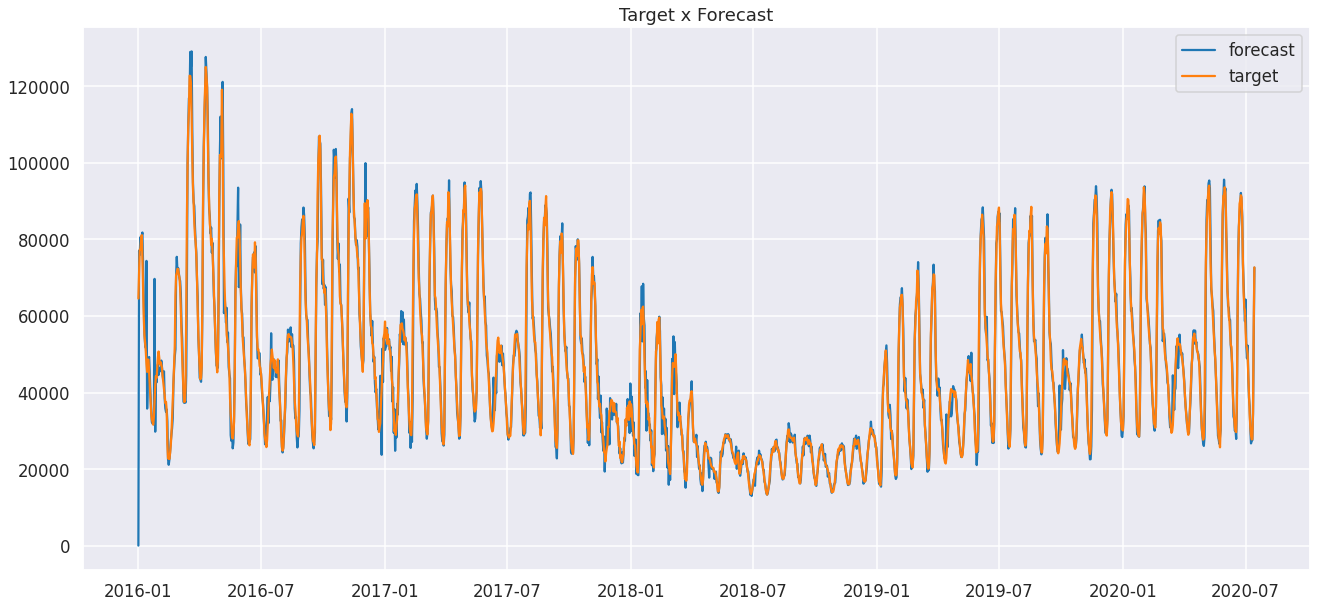

In [296]:
plot_model(df, eval(test_scores[0][0]))